# Histórico das atualizações

- Hélio - 06-07 18:23 Organização das seções com descrições conforme o contexto
- Bernado- 06-07 22:30 - Correção do algoritmo de força bruta, testes, gáficos e melhora na documentação
- Hélio - xx



# Enunciado do Problema

**Objetivo**

> Este projeto tem como objetivo a solução de um problema relacionado ao Tech Challenge Fase 2, do curso de Pós Gradução de IA para Devs da Fiap

**Definição do problema**

- O desafio consiste em projetar, implementar e testar um sistema que utilize algorítmos genéticos
para otimizar uma função ou resolver um problema complexo de otimização.

- Selecionamos o problema de otimização de rotas,que utiliza um dataset com localização de todas as cidades do Brasil,
que pode ser aplicados em empresas de logísticas, entregas de produtos,e que são amplamentes
usados em empresa de e-commerce, varejo em geral, etc.

**Testes e Resultados**
 - Realize testes para testar a eficácia do do algorítimo

**Documentação**
Forneça uma documentação completa do projeto incluindo:
- Descrição do problema
- Detalhes da implementação do algorítmo
- Análise dos resultados
- Conclusões.






# Entregável
**Participantes do Grupo 51**

- RM 355027 - José Hélio Araújo Andrade

- RM 356210 - Bernado Guimarães Tinti

**Links de referências**

- Video de apresentação no Youtube

- [Repositório Github](https://github.com/betinti/AlgoritmoGenetico-OtimizacaoDeRotas)

- [DataSet das cidades do Brasil obtido do Kaggle](https://colab.research.google.com/drive/1CzJozb4ODW4x3eoo89dBhHQgHiecXiJx#scrollTo=lal5IWWFpKFi&line=3&uniqifier=1)

# Importação de libs


In [1]:
# instalação de libs
# pip install deap folium ipywidgets numpy pandas IPython matplotlib

import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms
import random
from math import radians, sin, cos, sqrt, atan2
import folium
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, HTML
import time
import matplotlib.pyplot as plt

# Carregando o Dataset

Dataset com localização de todas as cidades brasileiras obtidas do Kaggle

**Link do Dataset:**
 https://colab.research.google.com/drive/1CzJozb4ODW4x3eoo89dBhHQgHiecXiJx#scrollTo=lal5IWWFpKFi&line=3&uniqifier=1


In [2]:
# Carregando o dataset
df = pd.read_csv('sample_data/BrazilianCities.csv')

df.head()

,ID,Cidade,Estado,Sigla,IBGE,Latitude,Longitude
0,1,ABADIA DE GOIÁS,GOIÁS,GO,5200050,-16.757264,-49.441220
1,2,ABADIA DOS DOURADOS,MINAS GERAIS,MG,3100104,-18.491063,-47.406365
2,3,ABADIÂNIA,GOIÁS,GO,5200100,-16.194723,-48.706812
3,4,ABAETÉ,MINAS GERAIS,MG,3100203,-19.156683,-45.448121
4,5,ABAETETUBA,PARÁ,PA,1500107,-1.721828,-48.878843


# Funções diversas
- Inicialização do algorítmo genético
- Função a fim de avaliar o TSP
- Função para criar a matriz de distâncias
- Função para calcular a distância Haversine
- Função para executar o algoritmo genético
- Função para criar a permutação de uma lista
- Implementação do algoritmo de força bruta
- Função para visualizar a rota no mapa
- Função para plotar o gráfico de convergência

In [9]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Funções diversas
# Inicialização do algorítmo genético
def init_ga(n_cities):
    toolbox.register("indices", random.sample, range(n_cities), n_cities)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxOrdered)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

# Avaliação do TSP
def evalTSP(individual, distance_matrix):
    distance = distance_matrix[individual[-1]][individual[0]]
    for i in range(len(individual) - 1):
        distance += distance_matrix[individual[i]][individual[i+1]]
    return distance,

# Permutations of a given list
def permutation(lst):
    # If lst is empty then there are no permutations
    if len(lst) == 0:
        return []
    # If there is only one element in lst then, only
    # one permutation is possible
    if len(lst) == 1:
        return [lst]
    # Find the permutations for lst if there are
    # more than 1 characters
    l = [] # empty list that will store current permutation
    # Iterate the input(lst) and calculate the permutation
    for i in range(len(lst)):
       m = lst[i]
       # Extract lst[i] or m from the list.  remLst is
       # remaining list
       remLst = lst[:i] + lst[i+1:]
       # Generating all permutations where m is first
       # element
       for p in permutation(remLst):
           l.append([m] + p)
    return l

# Função para calcular a distância Haversine
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # raio da Terra em km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# Implementação do algoritmo de força bruta
def brute_force_tsp(distance_matrix):
    n = len(distance_matrix)
    all_permutations = permutation(list(range(n)))
    best_route = None
    best_distance = float('inf')

    for perm in all_permutations:
        distance = sum(distance_matrix[perm[i]][perm[i+1]] for i in range(n-1))
        distance += distance_matrix[perm[-1]][perm[0]]  # Retorno à cidade inicial
        if distance < best_distance:
            best_distance = distance
            best_route = perm

    return best_route, best_distance

# Função para executar o algoritmo genético
def run_ga(distance_matrix, pop_size=300, n_generations=200, crossover_prob=0.7, mutation_prob=0.2):
    toolbox.register("evaluate", evalTSP, distance_matrix=distance_matrix)

    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=crossover_prob, mutpb=mutation_prob,
                                   ngen=n_generations, stats=stats, halloffame=hof, verbose=True)

    return hof[0], log

# Função para criar a matriz de distâncias
def create_distance_matrix(cities):
    n_cities = len(cities)
    distance_matrix = np.zeros((n_cities, n_cities))
    for i in range(n_cities):
        for j in range(i+1, n_cities):
            dist = haversine_distance(
                cities.iloc[i]['Latitude'],
                cities.iloc[i]['Longitude'],
                cities.iloc[j]['Latitude'],
                cities.iloc[j]['Longitude']
            )
            distance_matrix[i][j] = dist
            distance_matrix[j][i] = dist
    return distance_matrix

# Função para visualizar a rota no mapa
def plot_route(cities, route):
    m = folium.Map(location=[cities['Latitude'].mean(), cities['Longitude'].mean()], zoom_start=4)

    # Adicionar marcadores para cada cidade
    for i, city in cities.iterrows():
        folium.Marker(
            [city['Latitude'], city['Longitude']],
            popup=city['Cidade'],
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(m)

    # Adicionar linhas conectando as cidades na ordem da rota
    route_coords = [(cities.iloc[i]['Latitude'], cities.iloc[i]['Longitude']) for i in route]
    route_coords.append(route_coords[0])  # Fechar o ciclo
    folium.PolyLine(route_coords, color="blue", weight=2.5, opacity=0.8).add_to(m)

    return m

# Função para plotar o gráfico de convergência
def plot_convergence(log):
    gen = log.select("gen")
    min_fits = log.select("min")
    avg_fits = log.select("avg")

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(gen, min_fits, 'b-', label="Melhor fitness")
    ax.plot(gen, avg_fits, 'r-', label="Fitness médio")
    ax.set_xlabel("Geração")
    ax.set_ylabel("Fitness (Distância)")
    ax.legend(loc="upper right")
    ax.set_title("Convergência do Algoritmo Genético")
    plt.show()

# Implementação do Algorítmo Genético


# Interface visual e interativa
- Função para visualizar a rota no mapa
- Função para plotar o gráfico de convergência

**Ações:**
- Widget para seleção de cidades
- Botão 'Executar Otimização'


In [6]:
# Interface do usuário
def run_optimization(selected_cities, n_generations):
    if len(selected_cities) < 2:
        print("Por favor, selecione pelo menos 2 cidades.")
        return

    selected_df = df[df['Cidade'].isin(selected_cities)].reset_index(drop=True)
    distance_matrix = create_distance_matrix(selected_df)

    print("Cidades selecionadas:")
    print(selected_df[['Cidade', 'Latitude', 'Longitude']])

    print(distance_matrix)
    init_ga(len(selected_cities))

    start_time = time.time()
    best_route_ga, log = run_ga(distance_matrix, n_generations=n_generations)
    ga_time = time.time() - start_time

    ga_distance = evalTSP(best_route_ga, distance_matrix)[0]

    print(f"Algoritmo Genético - Melhor distância: {ga_distance:.2f} km")
    print(f"Tempo de execução do AG: {ga_time:.2f} segundos")

    best_route_names = [selected_df.iloc[i]['Cidade'] for i in best_route_ga]
    print("Rota do AG:", ' -> '.join(best_route_names))

    # Executar força bruta apenas se o número de cidades for menor ou igual a 10
    if len(selected_cities) <= 12:
        start_time = time.time()
        best_route_bf, bf_distance = brute_force_tsp(distance_matrix)
        bf_time = time.time() - start_time

        print(f"\nForça Bruta - Melhor distância: {bf_distance:.2f} km")
        print(f"Tempo de execução da Força Bruta: {bf_time:.2f} segundos")

        best_route_names_bf = [selected_df.iloc[i]['Cidade'] for i in best_route_bf]
        print("Rota da Força Bruta:", ' -> '.join(best_route_names_bf))
    else:
        print("\nForça Bruta não executada devido ao alto número de cidades (>10).")

    # Visualizar a rota no mapa
    m = plot_route(selected_df, best_route_ga)
    display(m)

    # Plotar gráfico de convergência
    plot_convergence(log)

In [7]:
n_generations_input = input("Digite o número de gerações: ")
n_generations = int(n_generations_input) if n_generations_input.isdigit() else 100

result = 0

# Widget para seleção de cidades
city_selector = widgets.SelectMultiple(
    options=df['Cidade'].tolist(),
    description='Selecione as cidades:',
    disabled=False
)

run_button = widgets.Button(description="Executar Otimização")
output = widgets.Output()

def on_button_clicked(_):
    with output:
        output.clear_output()
        print("Executando otimização...")
        run_optimization(city_selector.value, n_generations)

run_button.on_click(on_button_clicked)

display(city_selector)
display(run_button)
display(output)

SelectMultiple(description='Selecione as cidades:', options=('ABADIA DE GOIÁS', 'ABADIA DOS DOURADOS', 'ABADIÂ…

Button(description='Executar Otimização', style=ButtonStyle())

Output()

In [ ]:
# prompt: altere o código da função plot_route para exibir a distância total da rota, e a distança entre as cidades

def plot_route(cities, route):
    m = folium.Map(location=[cities['Latitude'].mean(), cities['Longitude'].mean()], zoom_start=4)

    # Adicionar marcadores para cada cidade
    for i, city in cities.iterrows():
        folium.Marker(
            [city['Latitude'], city['Longitude']],
            popup=city['Cidade'],
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(m)

    # Adicionar linhas conectando as cidades na ordem da rota
    route_coords = [(cities.iloc[i]['Latitude'], cities.iloc[i]['Longitude']) for i in route]
    route_coords.append(route_coords[0])
        total_distance += haversine_distance(city1['Latitude'], city1['Longitude'], city2['Latitude'], city2['Longitude'])

    # Adicionar texto com a distância total da rota
    folium.PolyLine(route_coords, color="black", weight=1.0, opacity=0.8).add_to(m)
    folium.Marker(route_coords[0], icon=folium.DivIcon(
        icon_size=(20, 20),
        icon_anchor=(0, 0),
        html=f"<b>Distância total: {total_distance:.2f} km</b>"
    )).add_to(m)

    # Adicionar texto com a distância entre as cidades
    for i in range(len(route) - 1):
        city1 = cities.iloc[route[i]]
        city2 = cities.iloc[route[i+1]]
        distance = haversine_distance(city1['Latitude'], city1['Longitude'], city2['Latitude'], city2['Longitude'])
        folium.Marker(route_coords[(i+1)//2], icon=folium.DivIcon(
            icon_size=(20, 20),
            icon_anchor=(0, 0),
            html=f"<b>{distance:.2f} km</b>"
        )).add_to(m)

    return m


In [2]:
import pygame
from pygame.locals import *

WHITE = (255, 255, 255)
WIDTH, HEIGHT = 800, 400

# Initialize Pygame
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("TSP Solver using Pygame")
clock = pygame.time.Clock()

running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_q:
                running = False

    screen.fill(WHITE)

KeyboardInterrupt: 

### Fluxograma do Algoritmo Genético
- Fazer uma breve descrição cada passo utilizado no nosso contexto
por exemplo:
- População inicial: usando o arquivo BrazilianCities.csv
<br>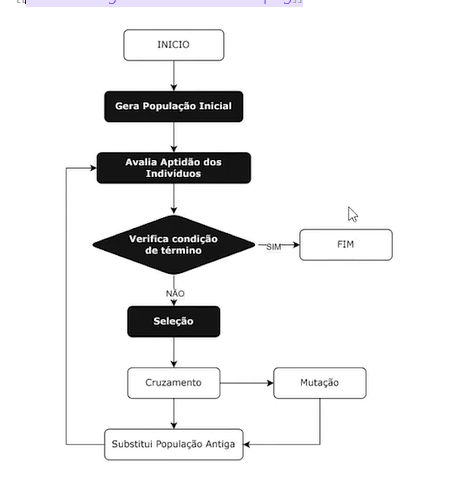

# Testes



## Comparando com Algoritmo Convencional
- Selecionar algoritmo convencional, usando força bruta para fins de comparação

In [ ]:
#Usando sempre 100 gerações

data = {'Algoritmo Genético':[0, 0, 1.31, 0.85, 1.1, 1.15, 0.97, 1.1, 1.03, 1.07, 1.65, 1.24],
        'Força Bruta':[0, 0, 0, 0, 0, 0, 0, 0.03, 0.27, 3.74, 49.2, 525.46 ]}

# Create DataFrame
df = pd.DataFrame(data)

df.head(12)

,Algoritmo Genético,Força Bruta
0,0.00,0.00
1,0.00,0.00
2,1.31,0.00
3,0.85,0.00
4,1.10,0.00
5,1.15,0.00
6,0.97,0.00
7,1.10,0.03
8,1.03,0.27
9,1.07,3.74


In [ ]:
# Sempre com 5 cidades

dataTests = {'Número Gerações':[100, 200, 300, 400, 500, 600],
        'Distancia':[4192.21, 4192.21, 4192.21, 4192.21, 4192.21, 4192.21]}

# Create DataFrame
df_g = pd.DataFrame(dataTests)

df_g.head(10)

,Número Gerações,Distancia
0,100,4192.21
1,200,4192.21
2,300,4192.21
3,400,4192.21
4,500,4192.21
5,600,4192.21


# Análises dos resultados


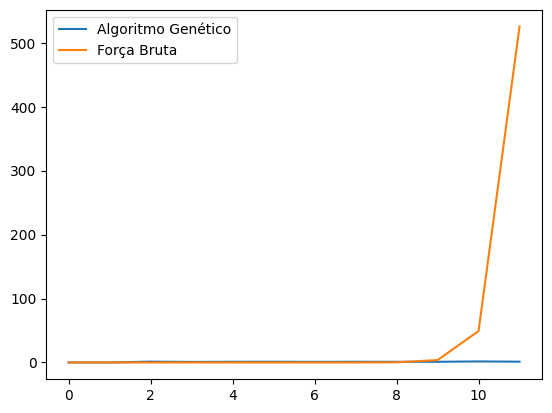

In [ ]:
# red dashes, blue squares and green triangles
plt.plot(df['Algoritmo Genético'], label="Algoritmo Genético")
plt.plot(df['Força Bruta'], label="Força Bruta")
plt.legend()
plt.show()

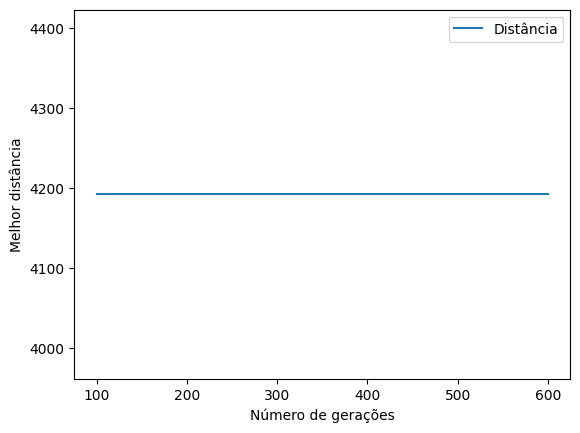

In [ ]:
plt.plot([100, 200, 300, 400, 500, 600], df_g['Distancia'], label="Distância")
plt.ylabel('Melhor distância')
plt.xlabel('Número de gerações')
plt.legend()
plt.show()

# Conclusões


# Referências


- Pasta compartilhada no google driver
https://drive.google.com/drive/folders/1sztfnyt-_sUGXQ6_6KqhvBWNSeg7s26E?usp=drive_link

# Formulario Interativo
